Going to try making a univariate multi-step forecasting model,just train the model on all of the ticker symbols.

If this works well, I am going to delete all of the above cells, as I'm tired of making new notebooks to try different things.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



# settings
model_settings = {'epochs': 10, 'batch_size': 100, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 10, 'n_steps_out': 30, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
columns = [i for i in close_df.columns]
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [2]:
# func to split the time sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check to see if we're beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input, output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# normalize data
# here will go the function that will prepare the X, y data when fitting the model
# normalize, split_sequence, reshape
global scaler_dict
scaler_dict = {}
def prep_data(data, n_steps_in, n_steps_out):
    # data is a dataframe w/ one column
    df = data.to_frame()
    symbol = df.columns[0]
    scaler_dict[symbol] = MinMaxScaler(feature_range=(0,1))
    scaled = scaler_dict[symbol].fit_transform(df.values)
    X, y = split_sequence(scaled, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

In [13]:
# split train/test sets
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df[:(int(data_size * .7))]
# this below might help me not run into issues reshaping data for predictions
# might actually not be necessary now that I've figured out my predictions errors
# while (len(training_data) % model_settings['n_steps_in']) != 0:
    # training_data = training_data.iloc[1:]
test_data = close_df[(int(data_size * .7)):]

# comment out the below line if you want a specific number of predictions, this is mainly useful to see test vs predicted data
model_settings['n_steps_out'] = len(test_data)

In [14]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(model_settings['n_steps_in'], 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(model_settings['n_steps_out']))
model.compile(optimizer='adam', loss='mse')

In [15]:
# fit model
for epoch in range(model_settings['epochs']):
    print('Epoch #: ', epoch)
    for symbol in close_df.columns:
        print('Symbol: ', symbol)
        x_train, y_train = prep_data(training_data[symbol], model_settings['n_steps_in'], model_settings['n_steps_out'])
        model.fit(x_train, y_train, batch_size=model_settings['batch_size'], epochs=epoch+1, initial_epoch=epoch, verbose=1)

Epoch #:  0
Symbol:  ABEO
2/2 [==============================] - 2s 92ms/step - loss: 0.2794
Symbol:  ABIO
2/2 [==============================] - 0s 82ms/step - loss: 0.0480
Symbol:  ABMC
2/2 [==============================] - 0s 81ms/step - loss: 0.1683
Symbol:  ABMT
2/2 [==============================] - 0s 83ms/step - loss: 0.1966
Symbol:  ABUS
2/2 [==============================] - 0s 79ms/step - loss: 0.1157
Symbol:  ACER
2/2 [==============================] - 0s 72ms/step - loss: 0.1637
Symbol:  ACHFF
2/2 [==============================] - 0s 75ms/step - loss: 0.3328
Symbol:  ACRX
2/2 [==============================] - 0s 74ms/step - loss: 0.1555
Symbol:  ACST
2/2 [==============================] - 0s 72ms/step - loss: 0.0190
Symbol:  ACUR
2/2 [==============================] - 0s 82ms/step - loss: 0.1194
Symbol:  ADIL
2/2 [==============================] - 0s 84ms/step - loss: 0.0431
Symbol:  ADMA
2/2 [==============================] - 0s 80ms/step - loss: 0.1100
Symbol:  ADMP
2

In [33]:
# shape of the single sample of input data when making the prediction must be 1 sample, the # of input steps, and the single feature.
symbol = "MNKD"
x_input = training_data[symbol].to_frame()
x_input = scaler_dict[symbol].fit_transform(x_input.values)
x_input = x_input[-model_settings['n_steps_in']:]
# next line, b/c the data they feed there's before reshaping is 1D
x_input = x_input.reshape((-1))
x_input = x_input.reshape((1, model_settings['n_steps_in'], 1))
yhat = model.predict(x_input)
yhat = scaler_dict[symbol].inverse_transform(yhat)
print(yhat)

[[3.0924528 3.099959  3.047356  2.967523  2.9755733 2.8867457 2.8971207
  2.8740716 2.849495  2.7940583 2.7616007 2.764564  2.7627058 2.7206597
  2.65362   2.6204839 2.617505  2.5616395 2.5623796 2.526323  2.5191338
  2.4724264 2.4588466 2.4082093 2.411053  2.3948858 2.3675833 2.3350034
  2.3258255 2.350887  2.297606  2.2824352 2.2746205 2.247835  2.2428274
  2.210362  2.2568376 2.2539477 2.2269745 2.2263224 2.2138324 2.2301354
  2.200948  2.21305   2.250713  2.2289898 2.192021  2.2350993 2.2161317
  2.2092435 2.2571058 2.2624555 2.2681377 2.2541988 2.2341304 2.2273393
  2.2640946 2.2280762 2.222179  2.260906  2.26648   2.2659097 2.2701697
  2.2521656 2.223805  2.19959   2.23918   2.2093046 2.2013981 2.202441
  2.2004879 2.1666946 2.198426  2.1816087 2.1965022 2.1802502 2.1701634
  2.208817  2.1806688 2.1935306 2.1825738 2.144264  2.1477127 2.1408827
  2.2017417 2.1123486 2.1555476 2.1172376 2.1498034 2.1390367 2.1165688
  2.1307206 2.0943813 2.0710187 2.1052978 2.0988927 2.0811684 2.0

In [34]:
# prep a dataframe to make all of the data compatible
yhat = yhat.reshape((-1))
predicted = pd.DataFrame(yhat, columns=[symbol])
test_data = test_data.reset_index()
'''while len(predicted) > len(test_data):
    last_date = test_data['price_datetime'].iloc[-1]
    future_date = last_date + datetime.timedelta(days=1)
    while future_date.weekday() in [5,6]:
        future_date = future_date + datetime.timedelta(days=1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date, format='%Y-%m-%d')
    future_dates = {'price_datetime': future_date}
    test_data = test_data.append(future_dates, ignore_index=True)'''

predicted['price_datetime'] = test_data['price_datetime']
test_data = test_data.set_index('price_datetime')
predicted = predicted.set_index('price_datetime')

In [23]:
predicted.tail(5)

,IMGN
price_datetime,
2021-06-01,4.340025
2021-06-02,4.315416
2021-06-03,4.247671
2021-06-04,4.312513
2021-06-07,4.191392


In [24]:
test_data.tail(5)

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819
2021-06-04,1.705,3.6451,0.0620,0.08000,3.01,2.990,1.1174,1.490,0.5503,0.360,...,1.76,3.3500,1.610,4.695,3.0098,3.0529,4.350,0.9110,0.8187,5.1800
2021-06-07,1.740,3.6400,0.0735,0.06650,3.27,2.970,1.1486,1.550,0.5715,0.360,...,1.76,3.5000,1.630,5.240,3.2400,3.0000,4.250,0.9667,0.9148,5.3100


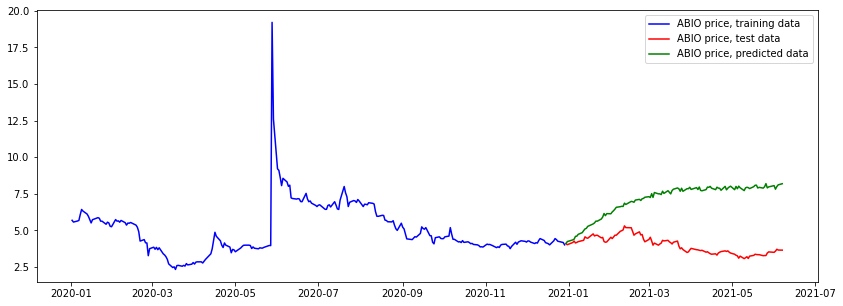

In [32]:
plt.figure(figsize=(14,5))
plt.plot(training_data[symbol], color='blue', label=f"{symbol} price, training data")
plt.plot(test_data[symbol], color='red', label=f"{symbol} price, test data")
plt.plot(predicted[f"{symbol}"], color='green', label=f"{symbol} price, predicted data")
plt.legend()

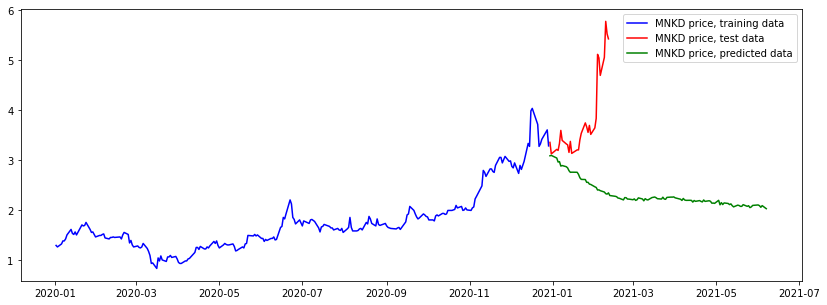

In [35]:
plt.figure(figsize=(14,5))
plt.plot(training_data[symbol], color='blue', label=f"{symbol} price, training data")
plt.plot(test_data[symbol].iloc, color='red', label=f"{symbol} price, test data")
plt.plot(predicted[f"{symbol}"], color='green', label=f"{symbol} price, predicted data")
plt.legend()

MLND MSE:  4.932218787829512
CPIX MSE:  0.3281093788686207
CEMI MSE:  6.300943601206896
SXTC MSE:  1.081021855782876
NMTR MSE:  0.5291503012184079


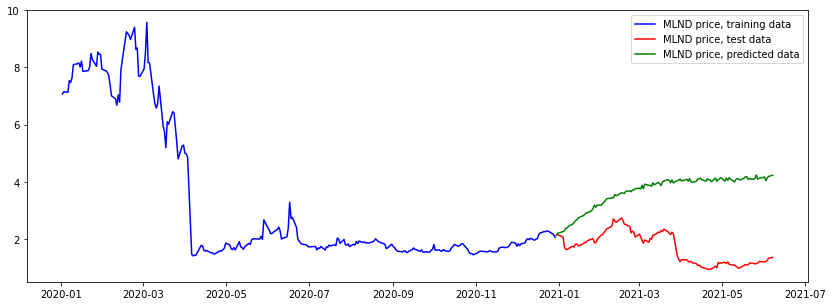

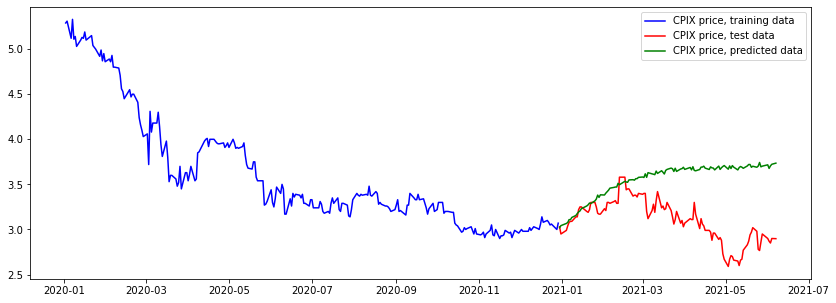

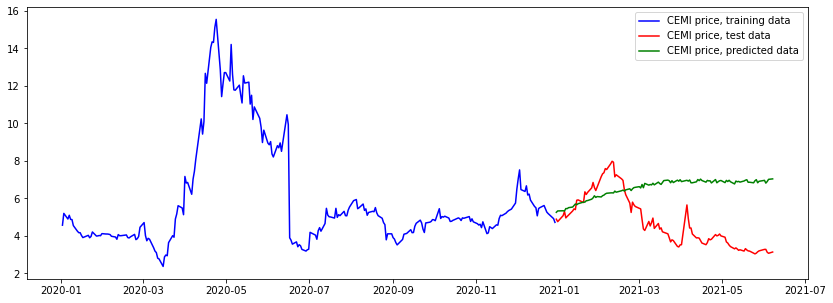

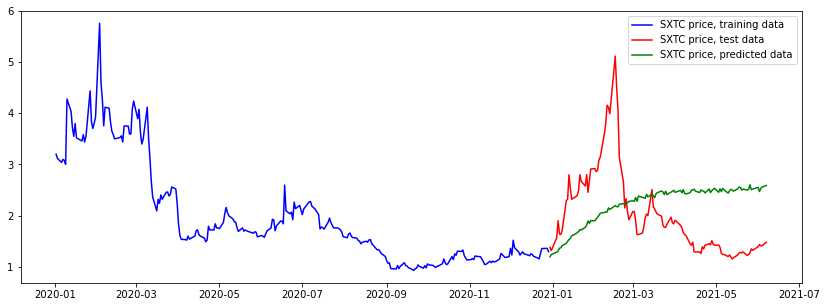

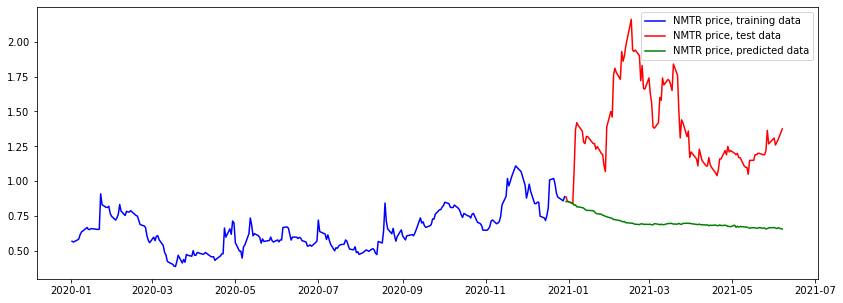

In [41]:
# script that predicts five symbols at random
import random

for i in range(5):
    rand = random.randrange(0, len(close_df.columns))
    symbol = training_data.columns[rand]

    # predict
    x_input = training_data[symbol].to_frame()
    x_input = scaler_dict[symbol].fit_transform(x_input.values)
    x_input = x_input[-model_settings['n_steps_in']:]
    # next line, b/c the data they feed there's before reshaping is 1D
    x_input = x_input.reshape((-1))
    x_input = x_input.reshape((1, model_settings['n_steps_in'], 1))
    yhat = model.predict(x_input)
    yhat = scaler_dict[symbol].inverse_transform(yhat)
    yhat = yhat.reshape((-1))

    # deal w/ index
    predicted = pd.DataFrame(yhat, columns=[symbol])
    test_data = test_data.reset_index()
    predicted['price_datetime'] = test_data['price_datetime']
    test_data = test_data.set_index('price_datetime')
    predicted = predicted.set_index('price_datetime')
    plt.figure(figsize=(14,5))
    plt.plot(training_data[symbol], color='blue', label=f"{symbol} price, training data")
    plt.plot(test_data[symbol], color='red', label=f"{symbol} price, test data")
    plt.plot(predicted[f"{symbol}"], color='green', label=f"{symbol} price, predicted data")
    plt.legend()
    mse = mean_squared_error(test_data[symbol], predicted[symbol])
    print(f'{symbol} MSE: ', mse)

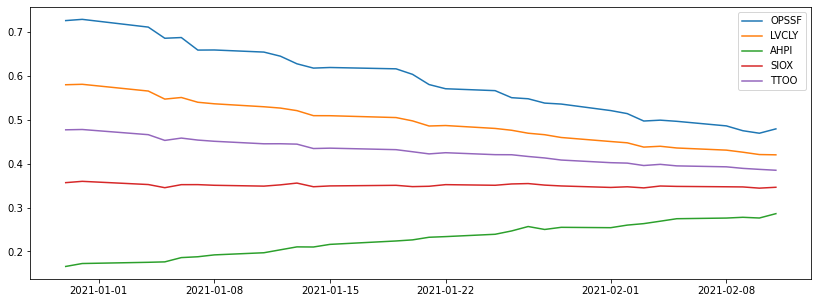

In [43]:
import random

for i in range(5):
    rand = random.randrange(0, len(close_df.columns))
    symbol = training_data.columns[rand]

    x_input = training_data[symbol].to_frame()
    x_input = scaler_dict[symbol].fit_transform(x_input.values)
    x_input = x_input[-model_settings['n_steps_in']:]
    # next line, b/c the data they feed there's before reshaping is 1D
    x_input = x_input.reshape((-1))
    x_input = x_input.reshape((1, model_settings['n_steps_in'], 1))
    yhat = model.predict(x_input)
    # yhat = scaler_dict[symbol].inverse_transform(yhat)
    yhat = yhat.reshape((-1))

    if i == 0:
    # deal w/ index
        predicted = pd.DataFrame(yhat, columns=[symbol])
        test_data = test_data.reset_index()
        predicted['price_datetime'] = test_data['price_datetime'].iloc[:30]
        test_data = test_data.set_index('price_datetime')
        predicted = predicted.set_index('price_datetime')
    else:
        predicted[symbol] = yhat
    if i == 4:
        plt.figure(figsize=(14,5))
        for symbol in predicted.columns:
            plt.plot(predicted[symbol], label=symbol)
        plt.legend()